In [33]:
#https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import nltk


In [8]:
df_pedidos = pd.read_pickle('dados/pedidos_texto.pkl').sample(1000)
df_pedidos_txt = pd.DataFrame({'IdPedido': df_pedidos['IdPedido'], 'TextoPedidoAgrupado': df_pedidos['ResumoSolicitacao'].fillna('') + ' ' + df_pedidos['DetalhamentoSolicitacao'].fillna('')})
df_pedidos_txt.head()


,IdPedido,TextoPedidoAgrupado
1444,3907890,Acesso ao meu INSS Não consigo acessar o meu ...
17965,1665586,Declaração final de Espolio de 2019 Como faço ...
56942,2184542,eu só tenho só você para perguntar se fiz dire...
8768,1998096,"Minha bisavó era índia, existem documentos que..."
39697,1553252,Como obter as Normais Climatológicas (Evapotra...


In [6]:
model = SentenceTransformer('rufimelo/Legal-BERTimbau-sts-base-ma-v2')


In [9]:
embeddings = model.encode(list(df_pedidos_txt['TextoPedidoAgrupado']), show_progress_bar=True)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [10]:
embeddings.shape


(1000, 768)

In [11]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [13]:
umap_embeddings.shape

(1000, 5)

In [16]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

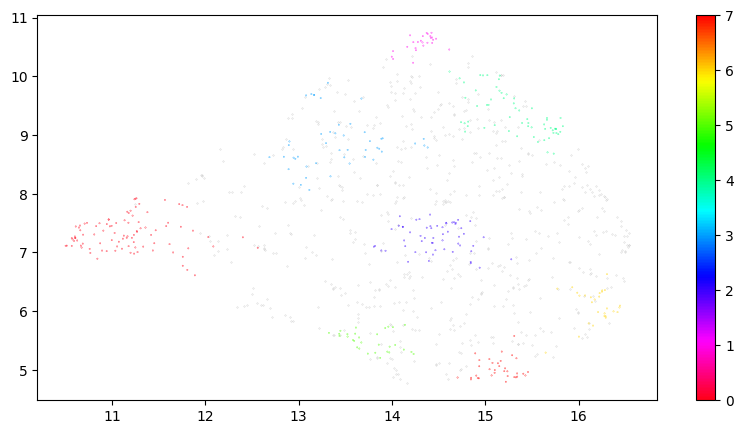

In [19]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [22]:
df_pedidos_txt['Topic'] = cluster.labels_
docs_per_topic = df_pedidos_txt.groupby(['Topic'], as_index = False).agg({'TextoPedidoAgrupado': ' '.join})


In [25]:
df_pedidos_txt['Topic'].value_counts()

-1    624
 0     95
 4     60
 2     57
 3     47
 7     34
 5     30
 6     28
 1     25
Name: Topic, dtype: int64

In [23]:
docs_per_topic

,Topic,TextoPedidoAgrupado
0,-1,Declaração final de Espolio de 2019 Como faço ...
1,0,Acesso ao meu INSS Não consigo acessar o meu ...
2,1,OUVIDORIA SOLICITO INFORMAÇÃO SOBRE ANO EM QUE...
3,2,Solicitação das bases do SINAN-Tuberculose de ...
4,3,Gostaríamos de receber uma cópia do contrato S...
5,4,eu só tenho só você para perguntar se fiz dire...
6,5,Concurso Revisor Braille Solicito informação s...
7,6,Informações sobre o curso de Ciências Sociais ...
8,7,Atuação do Cargo de Pregoeiro na Universidade ...


In [47]:
def c_tf_idf(documents, m, ngram_range=(1, 1), stopwords="english"):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stopwords).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes


In [41]:
stopwords = nltk.corpus.stopwords.words('portuguese')
tf_idf, count = c_tf_idf(docs_per_topic.TextoPedidoAgrupado.values, m=df_pedidos_txt.shape[0], stopwords=stopwords)


In [42]:
tf_idf.shape

(10118, 9)

In [44]:
count

CountVectorizer(stop_words=['a', 'à', 'ao', 'aos', 'aquela', 'aquelas',
                            'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até',
                            'com', 'como', 'da', 'das', 'de', 'dela', 'delas',
                            'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é',
                            'ela', 'elas', 'ele', 'eles', ...])

In [48]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)


,Topic,Size
0,-1,0
1,0,0
2,1,0
3,2,0
4,3,0
5,4,0
6,5,0
7,6,0
8,7,0


In [49]:
top_n_words

{-1: [('dados', 0.007945293103086812),
  ('solicito', 0.007644537772965072),
  ('sobre', 0.007463008909430829),
  ('gostaria', 0.007291306900184531),
  ('informações', 0.006960323795688674),
  ('acesso', 0.0067333961162888934),
  ('processo', 0.006712413476975189),
  ('brasil', 0.006693928038927299),
  ('informação', 0.006536483769445091),
  ('nº', 0.0064921323294727835),
  ('ano', 0.0063613473018586195),
  ('prezados', 0.006334587345222824),
  ('cópia', 0.006172190899636054),
  ('contrato', 0.006139923440400547),
  ('número', 0.006095638928492505),
  ('2016', 0.006077196357876201),
  ('documentos', 0.006023114531132034),
  ('2015', 0.005857031157595814),
  ('solicitação', 0.005856944535803294),
  ('saber', 0.005803361631300623)],
 0: [('auxílio', 0.03846275653557985),
  ('emergencial', 0.03262746125091608),
  ('pois', 0.028290861945799054),
  ('renda', 0.02405748209963078),
  ('saber', 0.023791810991289075),
  ('auxilio', 0.019936449559358936),
  ('parcela', 0.019337250053757096),
  (